##Imports and definitions

In [ ]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Check version of tensorflow
!pip install 'tensorflow==1.15.0'
import tensorflow as tf
#tf.__version__

In [ ]:
!pip install 'kaggle-environments>=0.1.6'

In [ ]:
!apt-get update
!apt-get install -y cmake libopenmpi-dev python3-dev zlib1g-dev
!pip install "stable-baselines[mpi]==2.9.0"

###Environment

In [ ]:
from kaggle_environments import make, evaluate
from gym import spaces

class ConnectFourGym:
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(self.rows,self.columns,1), dtype=np.int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1)
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1), reward, done, _

In [48]:
import os
from stable_baselines.bench import Monitor 
from stable_baselines.common.vec_env import DummyVecEnv

# Create directory for logging training information
log_dir = "ppo/"
os.makedirs(log_dir, exist_ok=True)

# Create ConnectFour environment
env = ConnectFourGym()

# Logging progress
monitor_env = Monitor(env, log_dir, allow_early_resets=True) 
                      #info_keywords=('reward','done'))

# Create a vectorized environment
vec_env = DummyVecEnv([lambda: monitor_env])

##Training

###Build

In [ ]:
from stable_baselines.a2c. 

In [16]:
from stable_baselines import PPO1, A2C 
from stable_baselines.a2c.utils import conv, linear, conv_to_fc
from stable_baselines.common.policies import CnnPolicy, MlpPolicy

In [ ]:
#@title model_OG
# Neural network for predicting action values
def modified_cnn_OG(scaled_images, **kwargs):
    activ = tf.nn.relu
    layer_1 = activ(conv(scaled_images, 'c1', n_filters=32, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = activ(conv(layer_1, 'c2', n_filters=64, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_3 = conv_to_fc(layer_2)
    return activ(linear(layer_3, 'fc1', n_hidden=512, init_scale=np.sqrt(2)))  

class CustomCnnPolicy_OG(CnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicy_OG, self).__init__(*args, **kwargs, cnn_extractor=modified_cnn_OG)
        
# Initialize agent
model_OG = PPO1(CustomCnnPolicy_OG, vec_env, verbose=1)

In [49]:
# Neural network for predicting action values
def modified_cnn_X(scaled_images, **kwargs):
    activ = tf.nn.relu
    layer_1 = activ(conv(scaled_images, 'c1', n_filters=64, filter_size=2, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = conv_to_fc(layer_1)
    layer_3 = activ(linear(layer_2, 'fc1', n_hidden=256, init_scale=np.sqrt(2)))
    return activ(linear(layer_3, 'fc2', n_hidden=512, init_scale=np.sqrt(2)))  

class CustomCnnPolicyX(CnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicyX, self).__init__(*args, **kwargs, cnn_extractor=modified_cnn_X)
        
# Initialize agent
modelX = PPO1(CustomCnnPolicyX, vec_env, verbose=0)

In [ ]:
## RESET ENV AND MODELS
if False:
    log_dir = "ppo/"
    os.makedirs(log_dir, exist_ok=True)
    monitor_env = Monitor(env, log_dir, allow_early_resets=True)
    vec_env = DummyVecEnv([lambda: monitor_env])
    modelX = PPO1(CustomCnnPolicyX, vec_env, verbose=0)
    model_OG = PPO1(CustomCnnPolicy_OG, vec_env, verbose=0)

###Train

In [50]:
def agentX(obs, config, model=modelX, debug=False):
    # Use the best model to select a column
    col, _ = model.predict(np.array(obs['board']).reshape(6,7,1))
    if debug:
        print("ModelX as player {} predicts: {}".format(obs.mark, col))
    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    # If not valid, select random move. 
    if is_valid:
        return int(col)
    else:
        if debug:
            print(">>> ModelX as {} guesses randomly: {}".format(obs.mark, col))
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [46]:
# Training agents
from heuristic_v8 import my_agent as heuristic
from test_agent_v6 import my_agent as test_agent

In [ ]:
agent_order = {0:agentX, 1:agentX, 2:agentX,
               3:agentX, 4:agentX, 5:agentX,
               6:agentX, 7:agentX, 8:agentX, 
               9:agentX} 

1024 steps against negamax took 0.0 minutes and 4.79 seconds.
1024 steps against <function agentX at 0x7f67eb65aea0> took 0.0 minutes and 4.47 seconds.
1024 steps against <function my_agent at 0x7f68804efd90> took 0.0 minutes and 4.49 seconds.
1024 steps against <function agentX at 0x7f67eb65aea0> took 0.0 minutes and 4.48 seconds.
1024 steps against <function my_agent at 0x7f68a4e7ad08> took 0.0 minutes and 4.48 seconds.
1024 steps against <function agentX at 0x7f67eb65aea0> took 0.0 minutes and 4.79 seconds.
1024 steps against <function my_agent at 0x7f68a4e7ad08> took 0.0 minutes and 4.5 seconds.
1024 steps against <function agentX at 0x7f67eb65aea0> took 0.0 minutes and 4.48 seconds.
1024 steps against random took 0.0 minutes and 4.51 seconds.
1024 steps against <function agentX at 0x7f67eb65aea0> took 0.0 minutes and 4.56 seconds.


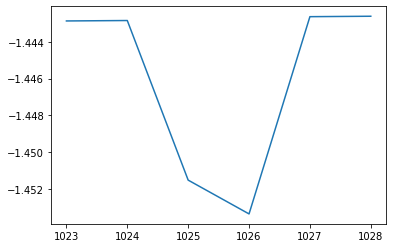

In [51]:
# Train agent
agent_order = {0:"negamax", 1:agentX, 2:heuristic,
               3:agentX, 4:test_agent, 5:agentX,
               6:test_agent, 7:agentX, 8:"random", 
               9:agentX}
              

for _ in range(1):
    for session in range(len(agent_order)): 
        start = time.time()
        nsteps = 10240 // len(agent_order)
        env = ConnectFourGym(agent2=agent_order[session])
        modelX.learn(total_timesteps=nsteps)
        stop = time.time()
        print (nsteps,"steps against",agent_order[session],"took",
            (stop-start)// 60,"minutes and",
            round((stop-start) % 60, 2), "seconds.")
        
# Plot cumulative reward
with open(os.path.join(log_dir, "monitor.csv"), 'rt') as fh:    
    firstline = fh.readline()
    assert firstline[0] == '#'
    df = pd.read_csv(fh, index_col=None)['r']
df.rolling(window=1024).mean().plot()
plt.show()

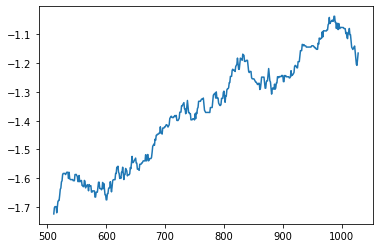

In [52]:
# Plot cumulative reward
with open(os.path.join(log_dir, "monitor.csv"), 'rt') as fh:    
    firstline = fh.readline()
    assert firstline[0] == '#'
    df = pd.read_csv(fh, index_col=None)#['r']
df['r'].rolling(window=512).mean().plot()
plt.show()

In [53]:
df.describe()

,r,l,t
count,1029.000000,1029.000000,1029.000000
mean,-1.453191,9.884354,46.419546
std,4.109154,2.993384,13.076082
min,-9.880952,4.000000,23.390674
25%,-0.857143,8.000000,35.212198
50%,1.095238,10.000000,46.426579
75%,1.214286,12.000000,57.842513
max,1.380952,19.000000,68.577620


In [ ]:
for _ in range(5):
    start = time.time()
    nsteps = 102400 // 5
    env = ConnectFourGym(agent2=agentX)
    modelX.learn(total_timesteps=nsteps)
    stop = time.time()
    print (nsteps,"steps against AgentX took",
        (stop-start)// 60,"minutes and",
        round((stop-start) % 60, 2), "seconds.")
        
# Plot cumulative reward
with open(os.path.join(log_dir, "monitor.csv"), 'rt') as fh:    
    firstline = fh.readline()
    assert firstline[0] == '#'
    df = pd.read_csv(fh, index_col=None)['r']
df[(-102400//5):].rolling(window=1024).mean().plot()
plt.show()

In [14]:
modelX.save('modelX1')

In [15]:
del modelX
modelX =  PPO1.load('/content/modelX.zip')

##Evaluation

In [ ]:
def get_win_percentages(agent1, agent2, n_rounds=1):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 4))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 4))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))
    return outcomes

In [ ]:
def trained_agent(obs, config, model=modelX, debug=True):
    # Use the best model to select a column
    col, _ = model.predict(np.array(obs['board']).reshape(6,7,1))
    if debug:
        print("Trained model {} predicts: {}".format(obs.mark, col))
    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    # If not valid, select random move. 
    if is_valid:
        return int(col)
    else:
        if debug:
            print(">>> Trained model {} guesses randomly: {}".format(obs.mark, col))
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [ ]:
modelX.load('/content/modelX.zip', env=None)

In [ ]:
modelX2 = PPO1.load('/content/modelX2.zip', env=None)

In [ ]:
start_time = time.time()
n_rounds=1000
agent1 = agentX #lambda x,y: trained_agent(x,y,model=modelX,debug=True)
#agent2 = lambda x,y: trained_agent(x,y,model=modelX,debug=True)
agent2 = test_agent
outcomes = get_win_percentages(agent1, agent2, n_rounds=n_rounds)
print ("Total time taken: {} seconds".format(time.time() - start_time))
print ("Time taken per round: {} seconds".format((time.time() - start_time)/n_rounds))

In [ ]:
A, B = 0, 0
for [a,b] in outcomes:
    A = A + a
    B = B + b
(A, B)

In [ ]:
outcomes